In [51]:
import json
import os
from typing import List

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import rasterio.plot
from rasterio.warp import calculate_default_transform, reproject, Resampling
from matplotlib.colors import ListedColormap
from stactools.core.utils.raster_footprint import RasterFootprint

In [52]:
def project_to_wgs84(href: str) -> str:
    dst_crs = "EPSG:4326"
    with rasterio.open(href) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds
        )
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        root, ext = os.path.splitext(href)
        wgs84_path = root + ".wgs84" + ext
        with rasterio.open(wgs84_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

    return wgs84_path


def manual_footprint(
        href,
        nodata=None,
        densification_factor=None,
        densification_distance=None,
        simplify_tolerance=None,
    ) -> List[List[float]]:
    with rasterio.open(href) as src:
        data_array = src.read(1)
        crs = src.crs
        transform = src.transform

    footprint = RasterFootprint(
        data_array,
        crs,
        transform,
        no_data=nodata,
        densification_factor=densification_factor,
        densification_distance=densification_distance,
        simplify_tolerance=simplify_tolerance,
    ).footprint()
    footprint_coordinates = footprint["coordinates"][0]
    print(footprint)

    root, _ = os.path.splitext(href)
    footprint_path = root + ".grid_footprint.json"
    with open(footprint_path, "w") as file_out:
        json.dump(footprint, file_out)

    return footprint_coordinates


def plot_data_and_footprint(
        data_array,
        transform,
        crs,
        cmap,
        vmin,
        vmax,
        footprint_xs,
        footprint_ys,
        figsize,
        xlim,
        ylim,
        tick_spacing,
        title,
    ):
    fig, ax = plt.subplots(figsize=figsize)
    # ax.set_facecolor((0.9, 0.9, 0.9))
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.xaxis.set_major_formatter("{x:0.1f}°")
    ax.yaxis.set_major_formatter("{x:0.1f}°")
    ax.xaxis.set_ticks(np.arange(xlim[0], xlim[1] + 0.1, tick_spacing))
    ax.yaxis.set_ticks(np.arange(ylim[0], ylim[1] + 0.1, tick_spacing))
    for tick in ax.get_yticklabels():
        tick.set_fontsize(9)
    for tick in ax.get_xticklabels():
        tick.set_fontsize(9)
    ax.set_xlabel("WGS84 Longitude", fontsize=9)
    ax.set_ylabel("WGS84 Latitude", fontsize=9)
    ax.set_title(title, fontsize=10)
    # ax.spines["top"].set_visible(False)
    # ax.spines["right"].set_visible(False)
    # ax.spines["bottom"].set_visible(False)
    # ax.spines["left"].set_visible(False)

    # cx.add_basemap(ax, crs=crs, source=cx.providers.Stamen.Terrain, attribution=False)
    # cx.add_basemap(ax, crs=crs, source=cx.providers.OpenStreetMap.Mapnik, attribution=False)
    # cx.add_basemap(ax, crs=crs, source=cx.providers.OpenTopoMap, attribution=False)
    # cx.add_basemap(ax, crs=crs, source=cx.providers.Stamen.Toner, attribution=False)
    # cx.add_basemap(ax, crs=crs, source=cx.providers.CartoDB.Voyager, attribution=False)
    # cx.add_basemap(ax, crs=crs, source=cx.providers.Stamen.TerrainBackground, attribution=False)
    cx.add_basemap(ax, crs=crs, source=cx.providers.Stamen.TonerLite, attribution=False)

    if data_array is not None:
        rasterio.plot.show(
            data_array,
            transform=transform,
            ax=ax,
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            interpolation="nearest",
        )

    ax.plot(footprint_xs, footprint_ys, color="red", marker="o", markerfacecolor="red", markersize=5)
    return ax

## ESA WorldCover

In [53]:
esaworldcover = "data/esa-worldcover/ESA_WorldCover_10m_2020_v100_S33E120_Map.tif"
with rasterio.open(esaworldcover) as src:
    data_array = src.read(1)
    crs = src.crs
    transform = src.transform
    colormap_def = src.colormap(1)
    bounds = src.bounds

footprint_coordinates = manual_footprint(esaworldcover)

{'type': 'Polygon', 'coordinates': (((120.0, -30.0), (120.0, -33.0), (123.0, -33.0), (123.0, -30.0), (120.0, -30.0)),)}


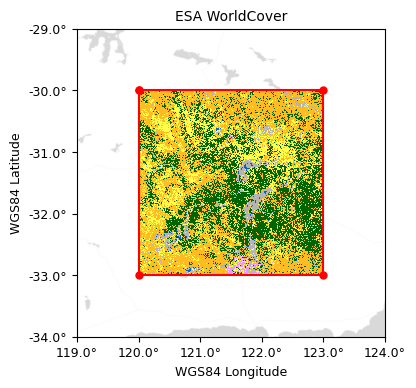

In [54]:
cmap = ListedColormap([np.array(colormap_def[i]) / 255 for i in range(len(colormap_def))])
vmin = 0
vmax = (len(colormap_def) - 1)

offset = 1
xlim = [bounds[0] - offset, bounds[2] + offset]
ylim = [bounds[1] - offset, bounds[3] + offset]
tick_spacing = 1

xs, ys = zip(*footprint_coordinates)

ax = plot_data_and_footprint(
    data_array=data_array,
    transform=transform,
    crs=crs,
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
    footprint_xs=xs,
    footprint_ys=ys,
    figsize=(4, 4),
    xlim=xlim,
    ylim=ylim,
    tick_spacing=tick_spacing,
    title="ESA WorldCover",
)
plt.savefig("images/esa-worldcover-tile.png", format="png", bbox_inches="tight")
plt.show()

## MODIS LST

In [55]:
modis_lst = "data/modis/MYD11A2/MYD11A2.A2023049.h28v11.061.2023059153505/MYD11A2.A2023049.h28v11.061.2023059153505_LST_Day_1km.tif"
modis_lst = "data/modis/MYD11A2/MYD11A2.A2023049.h12v02.061.2023059154534/MYD11A2.A2023049.h12v02.061.2023059154534_LST_Day_1km.tif"
modis_lst = "data/modis/MYD11A2/MYD11A2.A2023049.h12v04.061.2023059153953/MYD11A2.A2023049.h12v04.061.2023059153953_LST_Day_1km.tif"
modis_lst = "data/modis/MYD11A2/MYD11A2.A2023049.h12v12.061.2023059153602/MYD11A2.A2023049.h12v12.061.2023059153602_LST_Day_1km.tif"
modis_lst = "data/modis/MYD11A2/MOD11A2.A2023049.h29v11.061.2023059153030/MOD11A2.A2023049.h29v11.061.2023059153030_LST_Day_1km.tif"
modis_lst_wgs84 = project_to_wgs84(modis_lst)

with rasterio.open(modis_lst_wgs84) as src:
    data_array = src.read(1)
    crs = src.crs
    transform = src.transform
    bounds = src.bounds
    nodata = src.nodata

In [56]:
def plot_modis(data_array, transform, bounds, nodata, footprint_coordinates, png_file):
    masked_data_array = np.ma.masked_where(data_array==nodata, data_array)
    cmap = "viridis"
    mean = np.mean(masked_data_array)
    stdev = np.std(masked_data_array)
    # vmin = np.min(masked_data_array)
    # vmax = np.max(masked_data_array)
    vmin = mean - 2 * stdev
    vmax = mean + 2 * stdev

    offset = 3
    xlim = [bounds[0] - offset, bounds[2] + offset]
    ylim = [bounds[1] - offset, bounds[3] + offset]
    xlim = [115, 140]
    ylim = [-32.5, -17.5]
    tick_spacing = 5

    xs, ys = zip(*footprint_coordinates)

    ax = plot_data_and_footprint(
        data_array=masked_data_array,
        transform=transform,
        crs="EPSG:4326",
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        footprint_xs=xs,
        footprint_ys=ys,
        figsize=(7, 7),
        xlim=xlim,
        ylim=ylim,
        tick_spacing=tick_spacing,
        title="MODIS - Land Surface Temperature",
    )
    plt.savefig(png_file, format="png", bbox_inches="tight")
    plt.show()

### Tile

{'type': 'Polygon', 'coordinates': (((117.059555, -20.0), (127.0170592, -30.0), (138.5640646, -30.0), (127.7013327, -20.0), (117.059555, -20.0)),)}


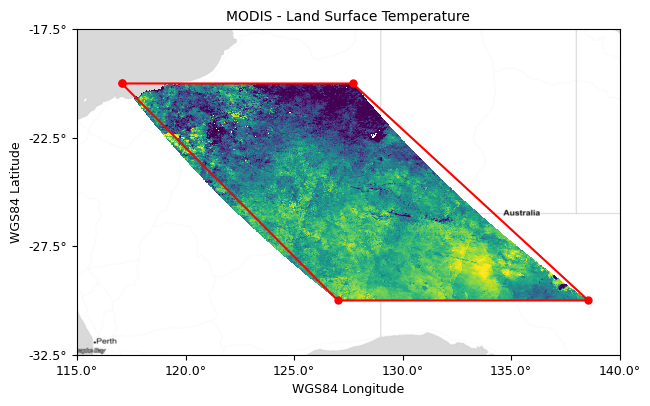

In [57]:
footprint_coordinates = manual_footprint(modis_lst)

plot_modis(
    data_array=data_array,
    transform=transform,
    bounds=bounds,
    nodata=nodata,
    footprint_coordinates=footprint_coordinates,
    png_file="images/modis-lst-tile.png"
)   

### no_data

{'type': 'Polygon', 'coordinates': (((127.0170592, -30.0), (138.5640646, -30.0), (127.7013327, -20.0), (119.0814927, -20.0), (118.1719921, -20.3333333), (117.5896551, -20.675), (117.5872033, -20.6833333), (117.5847538, -20.6916667), (127.0170592, -30.0)),)}


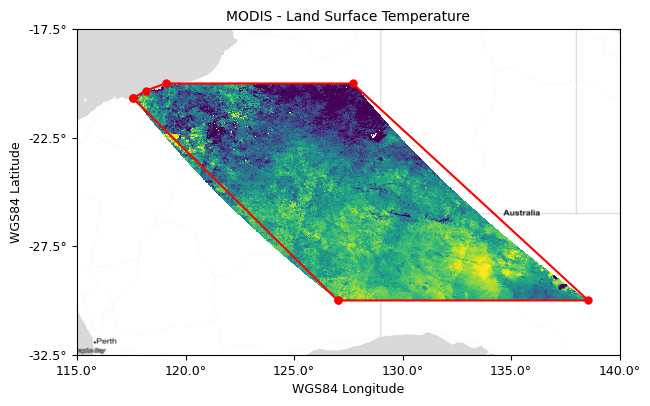

In [58]:
footprint_coordinates = manual_footprint(modis_lst, nodata=0)

plot_modis(
    data_array=data_array,
    transform=transform,
    bounds=bounds,
    nodata=nodata,
    footprint_coordinates=footprint_coordinates,
    png_file="images/modis-lst-nodata.png"
)

### densification_factor

{'type': 'Polygon', 'coordinates': (((127.0170592, -30.0), (130.866061, -30.0), (134.7150628, -30.0), (138.5640646, -30.0), (134.2833672, -26.6666667), (130.6881889, -23.3333333), (127.7013327, -20.0), (124.8280527, -20.0), (121.9547727, -20.0), (119.0814927, -20.0), (118.778311, -20.1111111), (118.4751453, -20.2222222), (118.1719921, -20.3333333), (117.9777023, -20.4472222), (117.7835907, -20.5611111), (117.5896551, -20.675), (117.5888376, -20.6777778), (117.5880204, -20.6805556), (117.5872033, -20.6833333), (117.5863866, -20.6861111), (117.5855701, -20.6888889), (117.5847538, -20.6916667), (120.2187379, -23.7944444), (123.3433498, -26.8972222), (127.0170592, -30.0)),)}


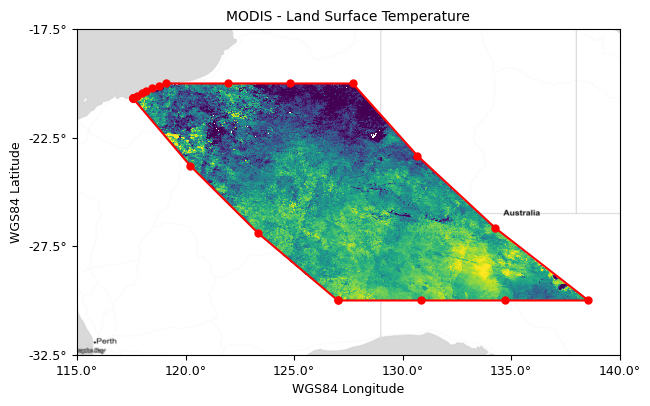

In [59]:
footprint_coordinates = manual_footprint(
    modis_lst,
    nodata=0,
    densification_factor=3
)

plot_modis(
    data_array=data_array,
    transform=transform,
    bounds=bounds,
    nodata=nodata,
    footprint_coordinates=footprint_coordinates,
    png_file="images/modis-lst-nodata-densification_factor.png"
)

### densification_distance

{'type': 'Polygon', 'coordinates': (((127.0170592, -30.0), (129.0939512, -30.0), (131.1708431, -30.0), (133.2477351, -30.0), (135.324627, -30.0), (137.4015189, -30.0), (138.5640646, -30.0), (136.1636854, -28.2013588), (133.9748242, -26.4027176), (131.9832199, -24.6040764), (130.1763562, -22.8054353), (128.5432512, -21.0067941), (127.7013327, -20.0), (125.7872587, -20.0), (123.8731848, -20.0), (121.9591108, -20.0), (120.0450368, -20.0), (119.0814927, -20.0), (118.1719921, -20.3333333), (117.5896551, -20.675), (117.5872033, -20.6833333), (117.5847538, -20.6916667), (119.0548018, -22.4903079), (120.6824972, -24.288949), (122.4776778, -26.0875902), (124.4515573, -27.8862314), (126.6169128, -29.6848726), (127.0170592, -30.0)),)}


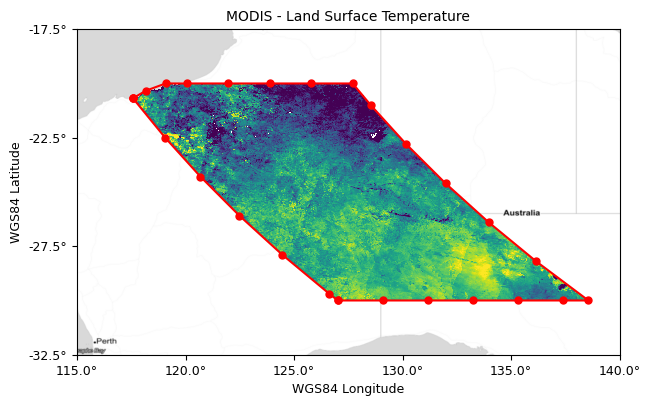

In [60]:
footprint_coordinates = manual_footprint(
    modis_lst,
    nodata=0,
    densification_distance=200000
)

plot_modis(
    data_array=data_array,
    transform=transform,
    bounds=bounds,
    nodata=nodata,
    footprint_coordinates=footprint_coordinates,
    png_file="images/modis-lst-nodata-densification_distance.png"
)

### simplify_tolerance

{'type': 'Polygon', 'coordinates': (((127.0170592, -30.0), (138.5640646, -30.0), (136.1636854, -28.2013588), (133.9748242, -26.4027176), (131.9832199, -24.6040764), (130.1763562, -22.8054353), (127.7013327, -20.0), (119.0814927, -20.0), (118.1719921, -20.3333333), (117.5896551, -20.675), (119.0548018, -22.4903079), (120.6824972, -24.288949), (122.4776778, -26.0875902), (124.4515573, -27.8862314), (127.0170592, -30.0)),)}


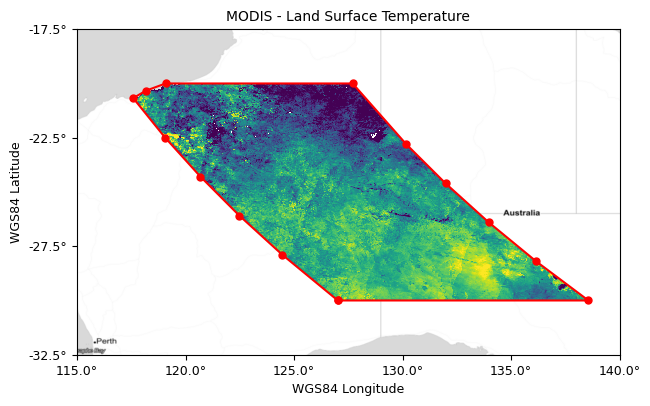

In [61]:
footprint_coordinates = manual_footprint(
    modis_lst,
    nodata=0,
    densification_distance=200000,
    simplify_tolerance=0.05
)

plot_modis(
    data_array=data_array,
    transform=transform,
    bounds=bounds,
    nodata=nodata,
    footprint_coordinates=footprint_coordinates,
    png_file="images/modis-lst-nodata-densification_distance-simplify_tolerance.png"
)